In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss

from utils_analysis import prepare_scores

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/mila/f/floresl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/mila/f/floresl/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/mila/f/floresl/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
metric = "f1"
test_filepath = "/home/mila/f/floresl/beam-search/data/squad/test.csv"
scores_filepath = "/home/mila/f/floresl/beam-search/results/final/bart-base_data_squad_checkpoint-220_squad.json"
temperature = 0.05

In [3]:
df_test = pd.read_csv(test_filepath)

targets = [str(s) for s in df_test["target"].fillna("")]
passage = [
    str(s) for s in df_test["source"].apply(lambda s: s.split(" | Question:")[0])
]
question = [
    str(s) for s in df_test["source"].apply(lambda s: s.split(" | Question:")[1])
]

In [4]:
results_json = json.load(open(scores_filepath, "r"))

In [5]:
results = prepare_scores(scores_filepath, targets, metric, temperature)  # type: ignore

scores = results.scores_dataframe
scores["target"] = targets
scores["beam_sentences"] = results_json["sentences"]
scores["passage"] = passage
scores["question"] = question

scores["length_normalized_log_probs_rank"] = ss.rankdata(
    -1 * scores["length_normalized_log_probs"]
)
scores["f1_rank"] = ss.rankdata(-1 * scores["f1"])
scores["beam_score_ratios_3_rank"] = ss.rankdata(-1 * scores["beam_score_ratios_3"])

/home/mila/f/floresl/beam-search/analysis/utils_analysis.py:49: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  abs(spearmanr(ground_truth_score, confidence_score_dict[str(k)]).statistic)  # type: ignore


In [8]:
log_probs = pd.DataFrame(results.scores_by_beam["beam_score_log_probs"]).values

In [61]:
# Look for examples where beam search ranks an output highly that standard
# log probs doesn't
rows_calibrated = scores.loc[
    (scores.length_normalized_log_probs_rank > 200)  # type: ignore
    & (scores.beam_score_ratios_3_rank < 200),  # type: ignore
    [
        "length_normalized_log_probs_rank",
        "beam_score_ratios_3_rank",
        "f1",
        "sentences",
        "target",
        "beam_sentences",
        "passage",
        "question",
    ],
].sort_values(
    by="beam_score_ratios_3_rank"
)  # type: ignore

# for i, row in rows_calibrated.iterrows():
#     seq_len = 200
#     plt.bar(x=list(range(100)), height=np.exp(seq_len * log_probs[i]))
#     plt.yscale("log")
#     plt.title(i)
#     plt.show()
#     print()

In [51]:
def plot_probs(probs: list[float]):
    plt.bar(x=list(range(len(probs))), height=probs)
    plt.yscale("log")
    plt.ylabel("Sequence Probability")
    plt.xlabel("Beam Number")
    plt.show()

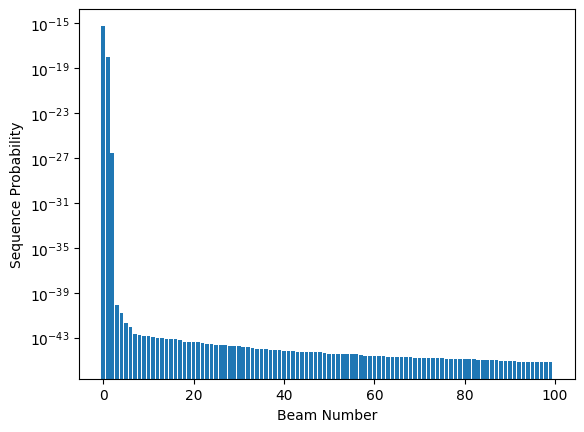

In [70]:
idx = 993
seq_len = 200
plot_probs(np.exp(seq_len * log_probs[idx]))

In [71]:
dict(rows_calibrated.loc[idx])

{'length_normalized_log_probs_rank': 685.0,
 'beam_score_ratios_3_rank': 119.0,
 'f1': 0.6666666666666666,
 'sentences': '2 weeks',
 'target': '2',
 'beam_sentences': ['2 weeks',
  '2 weeks each year',
  '2 weeks each year in mid June',
  '2 weeks each year in mid June. EAT! NewcastleGateshead, a festival of food and drink, runs for 2 weeks each year in mid June',
  '2 weeks each year in mid June. EAT! NewcastleGateshead, a festival of food and drink, runs for 2 weeks each year in mid June.',
  '2 weeks each year in mid June.In May, Newcastle and Gateshead host the Evolution Festival, a music festival held on the Newcastle and Gateshead Quaysides over the Spring bank holiday, with performances by acts from the world of Rock, Indie and Dance music, with performances by acts from the world of Rock, Indie and Dance music, with performances by acts from the world of Rock, Indie and Dance music, with performances by acts from the world of Rock, Rock and Dance music, with performances by act